# Prospector Master Plotting Code

In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes
import pandas as pd
from prospect.models.transforms import tage_from_tuniv


import fsps
import sedpy
import prospect
import numpy as np
from prospect.models import priors
from prospect.models.sedmodel import SedModel
import time
import scipy
import h5py
from scipy.special import gamma, gammainc
from prospect.utils.obsutils import fix_obs

import os
from prospect.utils.obsutils import fix_obs
from scipy.stats import truncnorm
from scipy.signal import savgol_filter

from prospect.models.templates import TemplateLibrary
from prospect.io.read_results import results_from, get_sps
from prospect.models.sedmodel import PolySedModel
from prospect.utils.plotting import quantile

from prospect.sources import CSPSpecBasis
from sedpy.observate import load_filters
from prospect.plotting.utils import sample_posterior
from astropy.cosmology import WMAP9

import corner as triangle
from prospect.io.read_results import traceplot, subcorner

matplotlib.rcParams['font.family'] = 'serif'
matplotlib.rcParams['axes.linewidth'] = 2.

In [2]:
from prospect.models.sedmodel import PolySpecModel

## Load in h5 file

In [8]:
run_params = {}
path = '/Users/anya/OneDrive - Northwestern University/BRIGHT/SGRB/GRB100117/'
file = '231117A_mcmc.h5'

res, obs, mod = results_from(file, dangerous=False)

In [9]:
parnames = np.array(res['theta_labels'], dtype='U20')

## Load in Parameter file to get model and sps functions

In [10]:
import param_231117A as param
# Instantiate the model
try:
    mod = param.load_model(**run_params)
    sps = param.load_sps(**run_params)
except AttributeError:
    mod = param.build_model(**run_params)
    sps = param.build_sps(**run_params)

In [11]:
mod

:::::::
<class 'prospect.models.sedmodel.PolySpecModel'>

Free Parameters: (name: prior) 
-----------
  dust2: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=3.0)
  tage: <class 'prospect.models.priors.TopHat'>(mini=0.0,maxi=10.721579045105102)
  tau: <class 'prospect.models.priors.LogUniform'>(mini=0.1,maxi=10.0)
  gas_logz: <class 'prospect.models.priors.TopHat'>(mini=-2.0,maxi=0.5)
  gas_logu: <class 'prospect.models.priors.TopHat'>(mini=-4,maxi=-1)
  massmet: <class 'param_231117A.MassMet'>(mass_mini=7,mass_maxi=13,z_mini=-1.0,z_maxi=0.19)
  spec_norm: <class 'prospect.models.priors.Normal'>(mean=1.0,sigma=0.2)

Fixed Parameters: (name: value [, depends_on]) 
-----------
  zred: [0.257] 
  mass: [1.e+10] <function massmet_to_mass at 0x16a26a7a0>
  logzsol: [-0.5] <function massmet_to_logzol at 0x16a26a830>
  sfh: [4] 
  imf_type: [1] 
  dust_type: [1] 
  dust1: [0.5] <function dust2_to_dust1 at 0x16a26a170>
  add_neb_emission: [ True] 
  add_neb_continuum: [ True] 
  nebemli

In [12]:
if 'spec_norm' in mod.params:
    run_params['opt_spec'] = True
else:
    run_params['opt_spec'] = False

In [13]:
run_params

{'opt_spec': True}

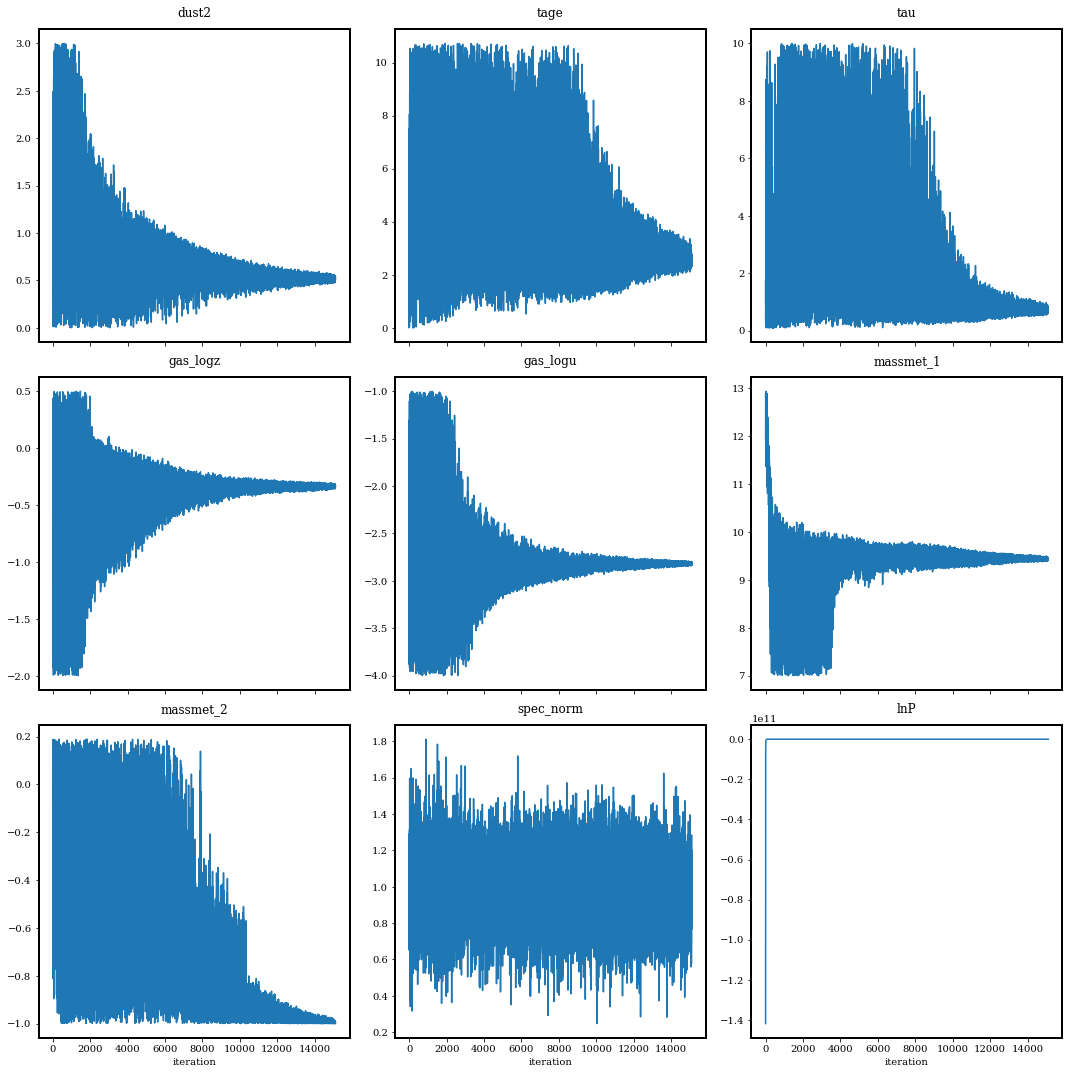

In [14]:
tracefig = traceplot(res, figsize=(15,15))

# Make some functions for corner plots
- age(tage, tau) will be used to convert from tage to mass-weighted age in corner plots
- SFR(tage, tau, mass) used for finding SFR distribution in corner plot
- sm(tm, logMF) is used to convert mass formed into stellar mass using the mass-weighted age


### Corner Codes
We take the Prospector output and create 100,000 uniformly weighted samples to build the posterior distributions. There is different code for phot-only and phot+spec fits.

In [15]:
def age(tage, tau):
    """
    Function to convert from tage and tau to mass-weighted age
    Note that mass-weighted age = tage - age(tage, tau)
    This only works for a delayed-tau SFH
    """
    age = 2*tau - tage**2/(tau*np.exp(tage/tau)-tau-tage)
    return age

def SFR(tage, tau, mass):
    """
    To determine SFR from delayed-tau SFH
    Takes in lists of tage, tau and mass
    Outputs SFR in M_sol/yr
    """
    psi_arr = []
    
    for i in np.arange(0, len(tage), 1):
        # for delay tau this function gives the (unnormalized) SFR 
        # for any t, tau combo in M_sun/Gyr
        tau_i = tau[i]
        sfr = lambda t,tau_i: (t) * np.exp(-t/tau_i)
        # now we numerically integrate this SFH from 0 to tage to get the mass formed
        times = np.linspace(0, tage[i], 1000)
        A = np.trapz(sfr(times, tau[i]), times)
        # and now we renormalize the formed mass to the actual mass value 
        # to get the the SFR in M_sun per Gyr 
        psi = mass[i] * sfr(tage[i], tau[i]) / A
        # if we want SFR in Msun/year
        psi /= 1e9
        psi_arr.append(psi)
    return np.array(psi_arr)

def sm(t_m, logMF):
    logtm = np.log10(t_m * 1e9)
    MF = 10**logMF
    logsm = 1.06 - 0.24 * logtm + 0.01*(logtm**2)
    
    sm = 10**logsm
    mass = sm * MF
    return np.log10(mass)


def specific_SFR(mass, z, sfr):
    # First solve for sSFR using full post. dist of mass and SFR
    # Take the mode perhaps? for redshift free
    sSFR = np.log10(np.array(sfr)/(10**np.array(mass)))
    # Find lookback time    
    type_SF = []
    # If z was fixed in the fit, t_lookback is a single value
    if type(z) == float:
        t_lookback = tage_from_tuniv(zred=z, tage_tuniv=1.0)*1e9

        for s in sSFR:
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if s >= sf_cond:
                type_SF.append('SF')
            elif (s < sf_cond) & (s > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')  
                
    else:
        for i in np.arange(0, len(z), 1):
            t_lookback = tage_from_tuniv(zred=z[i], tage_tuniv=1.0)*1e9
            
            sf_cond = np.log10(1/3/(t_lookback))
            q_cond = np.log10(1/20/(t_lookback))
            
            if sSFR[i] >= sf_cond:
                type_SF.append('SF')
            elif (sSFR[i] < sf_cond) & (sSFR[i] > q_cond):
                type_SF.append('T')
            else: 
                type_SF.append('Q')   
    
    SF_mode = scipy.stats.mode(type_SF)[0][0]
    
    return SF_mode, sSFR

def tmax_to_tage(tmax=None,redshift=None,**kwargs):
    return WMAP9.age(redshift).value*(tmax) # in Gyr
    
def theta_corner_spec(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    # Define some variables
    t_age_par = theta_samp[:, parnames.tolist().index('tage')]
    t_age = t_age_par.copy()
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]


    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    gaslogz = theta_samp[:, parnames.tolist().index('gas_logz')]

    # Convert from tage to mass-weighted age
    t_m =  t_age - age(t_age,tau)
    # Calculate SFR
    SFR_calc = SFR(t_age, tau, mass)

    stell_mass = sm(t_m, mass_log)

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas
    
    if 'zred' in parnames:
        zred = theta_samp[:, parnames.tolist().index('zred')]
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i]]
            new_theta.append(new_idx)
            
            
    else:
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i]]
            new_theta.append(new_idx)
            
            
        for i in np.arange(0, len(res['model_params']),1):
            if res['model_params'][i]['name'] == 'zred':
                if res['model_params'][i]['isfree'] == False:
                    zred = res['model_params'][i]['init'] 
                    
    SF_mode, sSFR = specific_SFR(stell_mass, zred, SFR_calc)
    print(SF_mode, np.quantile(sSFR, [0.16, 0.5, 0.84, 0.99]))


    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    return figure


def theta_corner_IR(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086


    # Define some variables
    t_age_par = theta_samp[:, parnames.tolist().index('tage')]
    t_age = t_age_par.copy()
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]


    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    gaslogz = theta_samp[:, parnames.tolist().index('gas_logz')]

    fagn = theta_samp[:, parnames.tolist().index('fagn')]
    tau_agn = theta_samp[:, parnames.tolist().index('agn_tau')]
    #duste_umin = theta_samp[:, parnames.tolist().index('duste_umin')]
    #duste_qpah = theta_samp[:, parnames.tolist().index('duste_qpah')]
    #duste_gamma = theta_samp[:, parnames.tolist().index('duste_gamma')]

    # Convert from tage to mass-weighted age
    t_m =  t_age - age(t_age,tau)
    # Calculate SFR
    SFR_calc = SFR(t_age, tau, mass) 

    stell_mass = sm(t_m, mass_log)

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas

    new_theta = []


    if 'zred' in parnames:
        zred = theta_samp[:, parnames.tolist().index('zred')]
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i],
                       gaslogz[i], fagn[i], tau_agn[i]] #, duste_umin[i], duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)


    else:
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], gaslogz[i],
                       fagn[i], tau_agn[i]] #, duste_umin[i], duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

   # AGN: 

    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)


    return figure

def theta_corner_phot(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]

    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]

    

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas and redshift if it exists

    if 'zred' in parnames:
        # Define some variables
        zred = theta_samp[:, parnames.tolist().index('zred')]

        tmax_par = theta_samp[:, parnames.tolist().index('tmax')]
        t_age = tmax_to_tage(tmax=tmax_par,redshift=zred)
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)   
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)

    else:
        # Define some variables
        t_age_par = theta_samp[:, parnames.tolist().index('tage')]
        t_age = t_age_par.copy()
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i]]
            new_theta.append(new_idx)
            
        print(np.median(stell_mass))

    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    
    return figure


def theta_corner_gen(results, param_latex, model, **kwargs):
    # Get parameter names 
    parnames = np.array(results['theta_labels'], dtype='U20')

     # Get the arrays we need (trace, wghts)
    samples = results['chain']
    xx = samples.copy()
    wghts = results.get('weights', None)

    # Resample posterior using weights to 100k uniformly-sampled weights    
    theta_samp = sample_posterior(xx, weights=wghts, nsample=100000)

    # Change from optical depth to dust: note must have dust2 as free parameter for this to work
    if 'dust1' in model.params:
        # Calculate total dust from dust1 and dust2 contributions: AV = (dust1 + dust2)*1.086 
        # dust1 = 0.5 * dust2
        dust2 = 1.5*1.086*theta_samp[:, parnames.tolist().index('dust2')]
    else:    
        dust2 = theta_samp[:, parnames.tolist().index('dust2')]*1.086

    # Define some variables
    tau = theta_samp[:, parnames.tolist().index('tau')]
    mass = 10**theta_samp[:, parnames.tolist().index('massmet_1')]
    mass_log = theta_samp[:, parnames.tolist().index('massmet_1')]

    logzsol = theta_samp[:, parnames.tolist().index('massmet_2')]
    
    duste_umin = theta_samp[:, parnames.tolist().index('duste_umin')]
    duste_qpah = theta_samp[:, parnames.tolist().index('duste_qpah')]
    duste_gamma = theta_samp[:, parnames.tolist().index('duste_gamma')]

    # We want to plot dust2, t_m, tau, SFR, M, Z , Z_gas and redshift if it exists

    if 'zred' in parnames:
        # Define some variables
        zred = theta_samp[:, parnames.tolist().index('zred')]

        tmax_par = theta_samp[:, parnames.tolist().index('tmax')]
        t_age = tmax_to_tage(tmax=tmax_par,redshift=zred)
        tau = theta_samp[:, parnames.tolist().index('tau')]
        
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 
        
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [zred[i], dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], duste_umin[i],
                       duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

    else:
        t_age_par = theta_samp[:, parnames.tolist().index('tage')]
        t_age = t_age_par.copy()
        # Convert from tage to mass-weighted age
        t_m =  t_age - age(t_age,tau)
        # Calculate SFR
        SFR_calc = SFR(t_age, tau, mass) 

        stell_mass = sm(t_m, mass_log)
    
        new_theta = []
        for i in np.arange(0, len(mass_log), 1):
            new_idx = [dust2[i], t_m[i], tau[i], SFR_calc[i], stell_mass[i], logzsol[i], duste_umin[i],
                       duste_qpah[i], duste_gamma[i]]
            new_theta.append(new_idx)

    new_theta = np.array(new_theta)

    # plot figure
    figure = triangle.corner(new_theta, quantiles=[0.16, 0.50, 0.84], show_titles=True, labels = param_latex,
                             color = 'darkcyan', hist_kwargs = {"alpha": 1, "linewidth":3}, 
                             title_fmt = ' .2f', contour_kwargs={"linewidths":3}, **kwargs)
    
    return figure

In [16]:
"""
data_type = "spec", "IR", or "phot"
    
Use "spec" if you are running a phot+spec fit 
Use "IR" if you are running a fit with MIR - FIR data and want to plot the dust emission
and AGN parameters
Use "phot1" if you are running a phot-only fit with redshift fixed
Use "phot2" if you are running a phot-only fit with redshift free
    
"""

data_type = 'spec'

SF [-9.56782362 -9.52377893 -9.48010909 -9.42359834]


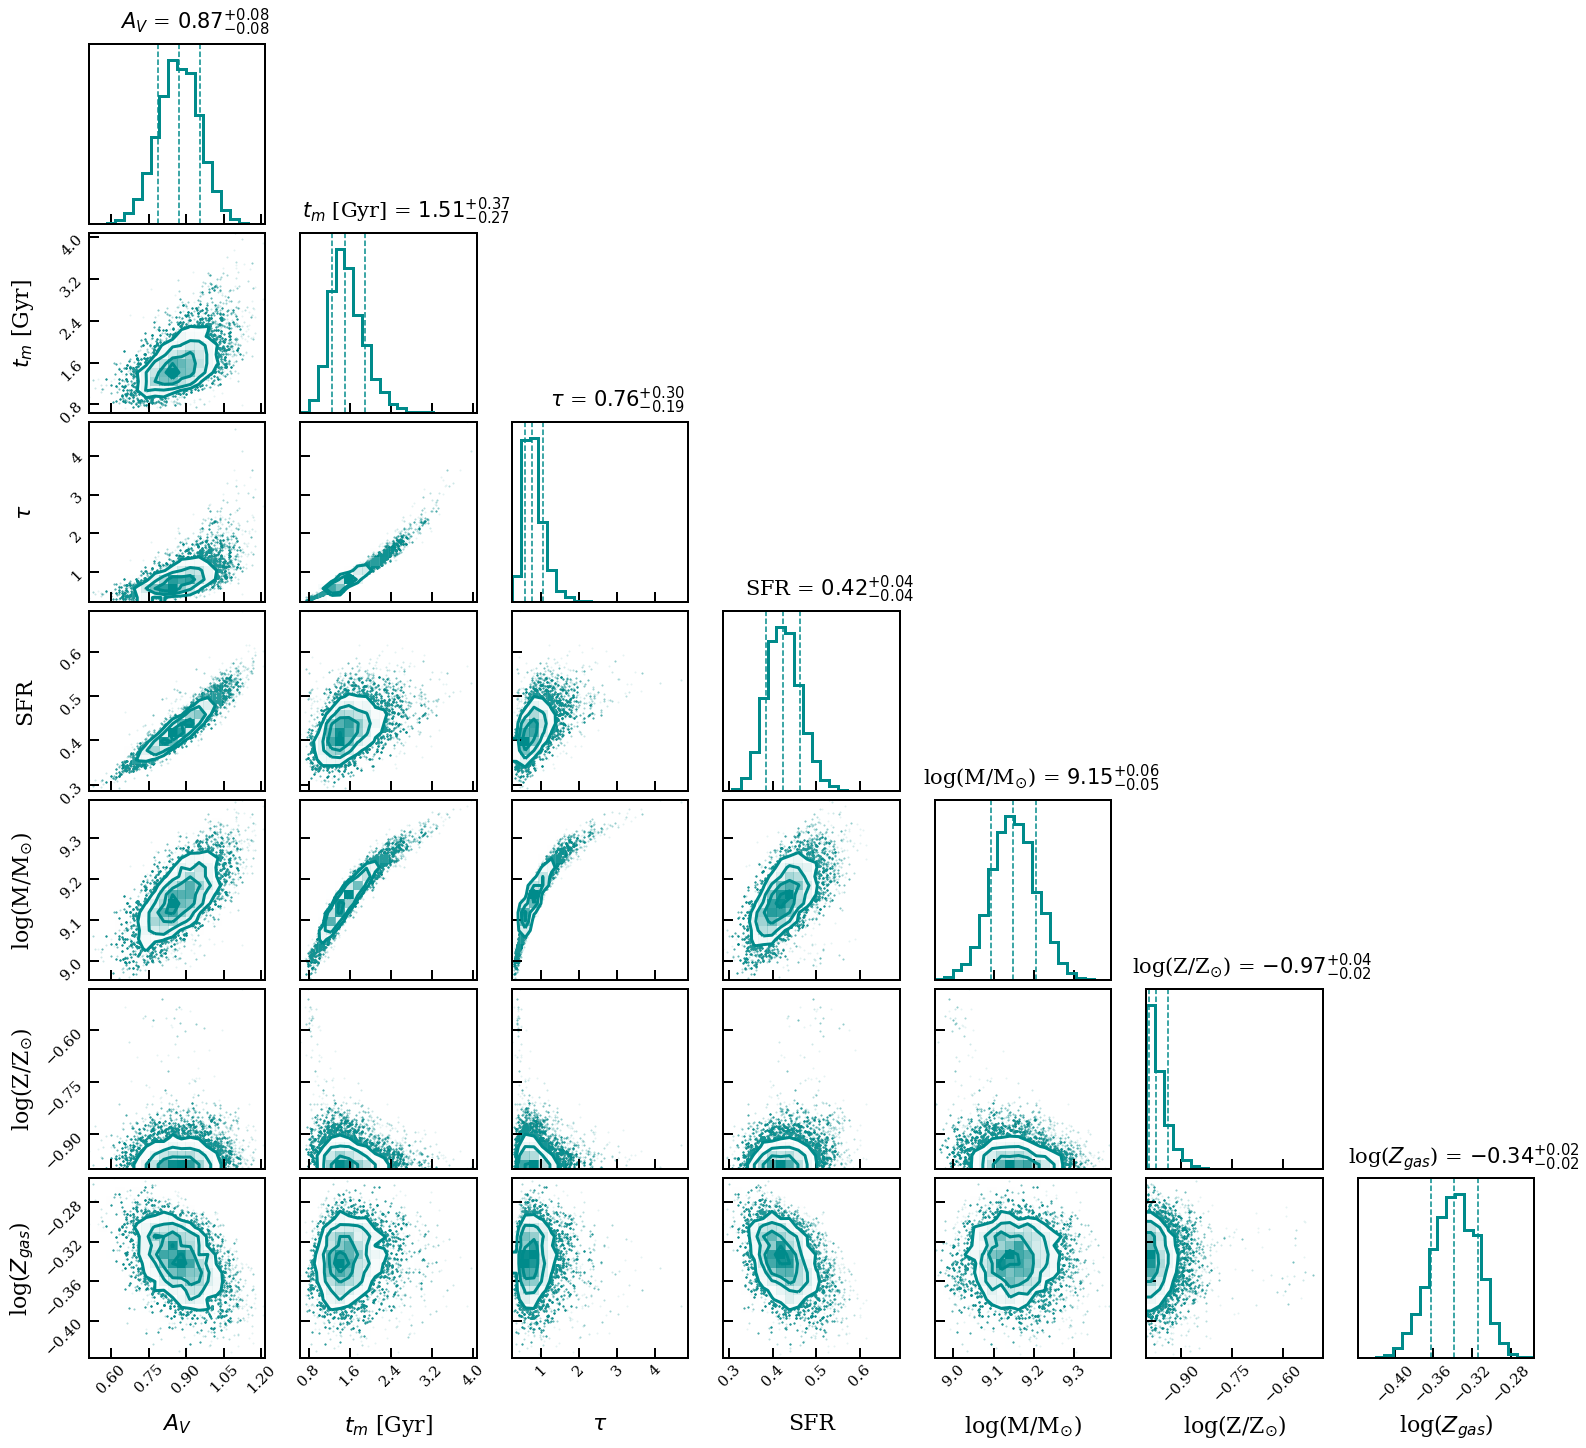

In [17]:
parnames_all_list = np.array([r'log(Z/Z$_{\odot}$)', r'$A_V/1.086$', r'log(${\tau}$)', r'N$_0$', r'log($Z_{gas}$)', r'log($U_{gas}$)',
                              '$t_m$ [Gyr]', 'log(M/M$_{\odot}$)', '$t_{age}$', '$f_{AGN}$','$\tau_{AGN}$',
                              'U$_{min}$', 'q$_{PAH}$', '$\gamma$'], dtype='U20')


platex = np.array([r'$A_V$', r'$t_{age}$ [Gyr]', r'$\tau$', r'log($Z_{gas}$)', r'log($U_{gas}$)',
                   r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)', r'N$_0$'], dtype='U20')

platex_spec = np.array([r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', r'log(M/M$_{\odot}$)', 
                                    r'log(Z/Z$_{\odot}$)',  r'log($Z_{gas}$)'], dtype='U20')

platex_AGN = np.array([r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', r'log(M/M$_{\odot}$)', 
                       r'log(Z/Z$_{\odot}$)', r'log($Z_{gas}$)',  r'$f_{AGN}$', r'$\tau_{AGN}$'], dtype='U20')
#, r'duste_Umin', r'duste_qpah', r'duste_gamma'

platex_phot1 = np.array([r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', 
                                        r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)'], dtype='U20')

platex_phot2 = np.array([r'z', r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', 
                                        r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)'], dtype='U20')


platex_photgen = np.array([r'$A_V$', r'$t_{m}$ [Gyr]', r'$\tau$', r'SFR', 
                           r'log(M/M$_{\odot}$)', r'log(Z/Z$_{\odot}$)',
                           r'U$_{min}$', r'q$_{PAH}$', r'$\gamma$'], dtype='U20')

# Note: you may have to change "platex" and number of subplots if what you are attempting to plot differs
# from the original code

if data_type == "spec":
        cornerfig = theta_corner_spec(res, platex_spec, model=mod, fig=plt.subplots(7,7,figsize=(22,20))[0], 
                                      title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                                       label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
elif data_type == "IR":
        cornerfig = theta_corner_IR(res, platex_AGN, model=mod, fig=plt.subplots(9,9,figsize=(22,20))[0], 
                                    title_kwargs={"fontsize": 18.5, 'x': 0.6, 'y':1.05}, 
                                    label_kwargs={"fontsize": 20}, label_fmt = ' .2f')
elif data_type == "phot1":
        cornerfig = theta_corner_phot(res, platex_phot1, model=mod, fig=plt.subplots(6,6,figsize=(22,20))[0], 
                                      title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                                      label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
elif data_type == "phot2":
        cornerfig = theta_corner_phot(res, platex_phot2, model=mod, fig=plt.subplots(7,7,figsize=(22,20))[0], 
                                      title_kwargs={"fontsize": 21, 'x': 0.6, 'y':1.05}, 
                                      label_kwargs={"fontsize": 22}, label_fmt = ' .2f')
        
elif data_type == "odd":
        cornerfig = theta_corner_gen(res, platex_photgen, model=mod, fig=plt.subplots(9,9,figsize=(22,20))[0], 
                                      title_kwargs={"fontsize": 18, 'x': 0.6, 'y':1.05}, 
                                      label_kwargs={"fontsize": 21}, label_fmt = ' .2f')


for ax in cornerfig.get_axes():
    ax.tick_params(axis='both', labelsize=15, length=10, width=2, direction='in')

plt.subplots_adjust(wspace=0.20, hspace=0.05)

#plt.savefig('finalplots/210726A_faint_K_zred_corner.png', dpi=300)


In [18]:
def makeSED(result, obs_dict, model, stellarpop):
    flatchain = result['chain']

    post_pcts = [quantile(flatchain[:, i], percents=50, weights=result.get("weights", None))
                 for i in range(model.ndim)]
    
    filternames = obs_dict['filternames']
    obs_dict["filters"] = sedpy.observate.load_filters(filternames)

    # Converged spectrum and photometric values
    mspec_conv, mphot_conv, _ = model.mean_model(post_pcts, obs_dict, sps=stellarpop)

    # Photometry
    wphot = obs_dict["phot_wave"] # Model/Observed photometric wavelengths
    obsphot = obs_dict['maggies']*3631e6 # Converted Observed photometry
    obsphot_unc = obs_dict['maggies_unc']*3631e6 # Converted Observed Photometry error
    modphot = mphot_conv * 3631e6

    fin_dict = {'phot_wave': wphot,
                'obs_phot': obsphot,
                'obs_phot_unc': obsphot_unc,
                'model_phot': modphot}

    # If observed spectrum was used in fit
    if obs['wavelength'] is not None:
        obswave = obs_dict['wavelength'] # Observed Spectrum Wavelengths
        mod_cal = model._speccal # Normalization factor
        full_mod_spec = (model._norm_spec)*3631e6 # Already normalized model spectrum
        wfull = stellarpop.wavelengths.copy()*(1+model.params.get('zred')) # Full wavelength range
        wspec = obs_dict["wavelength"] # Observed spec wavelength
        obsspec = (obs_dict['spectrum']/mod_cal) * 3631e6 #Observed Spectrum
        obserr = (obs_dict['unc']/mod_cal) * 3631e6 # Observed Spectrum Error
        
        if 'mask' in obs_dict:
            mask = obs_dict['mask']
    
            fin_dict['spec_wave'] = wspec[np.where(mask == True)]
            fin_dict['obs_spec'] = obsspec[np.where(mask == True)]
            fin_dict['obs_spec_err'] = obserr[np.where(mask == True)]
        else:
            fin_dict['spec_wave'] = wspec
            fin_dict['obs_spec'] = obsspec
            fin_dict['obs_spec_err'] = obserr
        

        fin_dict['model_spec'] = full_mod_spec
        fin_dict['mspecconv'] = mspec_conv
        fin_dict['full_spec_wave'] = wfull
        fin_dict['mod_cal'] = mod_cal


    # If observed spectrum was NOT used in fit
    else:
        a = 1 + model.params.get('zred')
        wspec = stellarpop.wavelengths.copy()
        wspec *= a #redshift them
        mspec_conv *= 3631e6 # Converted model spectrum

        fin_dict['model_spec'] = mspec_conv
        fin_dict['spec_wave'] = wspec
    
    return fin_dict

In [19]:
# Set whether you have a spec run and/or a constrained fit
if run_params['opt_spec'] == True:
    spec_run_bool = True # phot + spec fit
else:
    spec_run_bool = False # normal phot only fit

fin = makeSED(result = res, obs_dict = obs, model = mod, stellarpop = sps)

In [20]:
filt_wave = []
filt_trans = []
for filt in obs['filternames']:
    print(filt)
    lfilt = load_filters([filt])
    filt_wave.append(lfilt[0].wavelength.copy())
    filt_trans.append(lfilt[0].transmission.copy())
    
    
filt_wave = np.array(filt_wave, dtype=object)
filt_trans = np.array(filt_trans, dtype=object)

sdss_g0
sdss_r0
sdss_i0
sdss_z0
twomass_J
twomass_Ks


In [27]:
# You'll need to change this based on what you want to label your filters
#filt_labels = np.array(['u','g', 'r', 'i', 'z', 'J', 'H', 'K'])
filt_labels = np.array(['g', 'r', 'i', 'z', 'J', 'K'])
# If you need to multiply a curve by some number for plotting purposes
# SDSS * 1, NIR (JHK)*1e4, Y*1e-2
filt_mult = np.array([1, 1, 1, 1, 1e4, 1e4, 1e4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,1 , 1])

# Choose some colors for your transmission curves
# u, g, r, i, z, J, H, K, IR-1
#color_arr = np.array(['purple', 'navy', 'forestgreen', 'goldenrod', 'orange', 'palevioletred', 'red',
#                      'firebrick', 'darkred'])
color_arr = np.array(['orchid','navy', 'cornflowerblue', 'forestgreen', 'limegreen','goldenrod', 'orange', 'palevioletred', 'red',
                      'firebrick','darkred','slategray', 'darkslategray','black','black','black','black','black','black'])

other_colors = np.array(['orchid', 'orangered', 'cornflowerblue', 'slategray', 'darkslategray','black'])

# Compare Model and Obs (not smoothed)


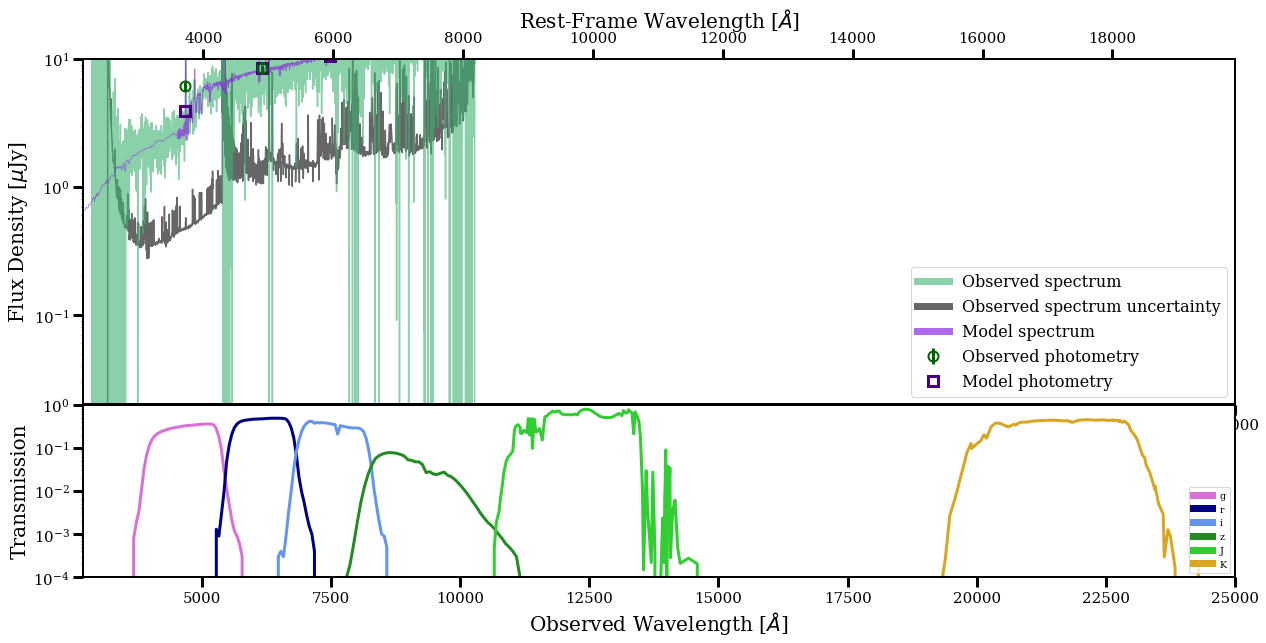

In [28]:
fig = plt.figure(figsize=(20,12))
    
# Set observed wavelength min and max
obs_wmin = 2.7e3
obs_wmax = 25e3
    
# Convert to rest-frame min and max for second axis
zred = mod.params.get('zred') # redshift
RF_wmin = obs_wmin/(1+zred)
RF_wmax = obs_wmax/(1+zred)

ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.4],
                    xlim=(obs_wmin, obs_wmax), ylim =(2e-2, 1e1)) #, xticklabels=[])
ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2], xlim = (obs_wmin, obs_wmax), ylim =(1e-4, 1e0))

# Adding in Rest-frame wavelength to top axis
ax3 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax3.tick_params(axis='x')
ax3.set_xlim((RF_wmin,RF_wmax))


# Observed photometry 


ax1.errorbar(fin['phot_wave'], fin['obs_phot'], yerr = fin['obs_phot_unc'], 
             label='Observed photometry', ecolor='darkgreen', 
             marker='o', markersize=10, ls='', lw=3, alpha=1.0, 
             markerfacecolor='none', markeredgecolor='darkgreen', markeredgewidth=2, zorder=4) 

if spec_run_bool == True:
    # Observed spectroscopy and error
    ax1.semilogy(fin['spec_wave'], fin['obs_spec'], color='mediumseagreen', alpha=0.6, 
                 zorder=1, label='Observed spectrum') # binned spec

    ax1.semilogy(fin['spec_wave'], fin['obs_spec_err'], color='k', alpha=0.6, 
                 zorder=0, label='Observed spectrum uncertainty')
     
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)

    # Model spectroscopy - just convering spec region
    ax1.semilogy(fin['full_spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='blueviolet', alpha=0.7, zorder=2)
    


else:
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)

    # Model spectroscopy - full wavelength range
    ax1.semilogy(fin['spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='blueviolet', alpha=0.7, zorder=2)
    #ax1.vlines(np.array([3727, 3729, 4862, 4932, 5007, 6564])*(1+zred), ymin=1e-3, ymax=1e3)
    
# Upper Limit
upper_limit = False
if upper_limit:
    up_l = np.array([f.wave_effective for f in load_filters(['LRISr_B', 'twomass_J'])])
    ax1.scatter(up_l, [10**(-0.4*25.9)*3631e6, 10**(-0.4*22.9)*3631e6], 
                color='darkgreen', marker='v', s=400)
    
    ulfilt = load_filters(['LRISr_B'])
    ul_wave = ulfilt[0].wavelength.copy()
    ul_trans = ulfilt[0].transmission.copy()
    
    #ax2.semilogy(ul_wave, ul_trans, alpha=1.0, label='i', lw=3, color='limegreen')
    
    
from matplotlib.legend_handler import HandlerLine2D
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)
    
# Axis 1 info
ax1.legend(loc='lower right', fontsize=16,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)


for i in np.arange(0, len(filt_wave), 1):
    ax2.semilogy(filt_wave[i], filt_trans[i]*filt_mult[i], alpha=1.0, label=filt_labels[i], lw=3, color=color_arr[i])

#ax2.ylabel('Transmission')
ax2.legend(loc='lower right', fontsize=9.5,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax2.set_ylabel(r'Transmission', fontsize=20)


ax2.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)

ax3.set_xlabel(r'Rest-Frame Wavelength [$\AA$]', fontsize=20)


import matplotlib.pyplot as plt

ax = plt.gca()

import matplotlib.axes

ax.tick_params(width=3)
ax1.tick_params(width=3, length=10, labelsize=15)
ax2.tick_params(width=3, length=10, labelsize=15)
ax3.tick_params(width=3, length=10, labelsize=15)

#plt.savefig('finalplots/210726A_K_muse_SED.png', dpi=300)

plt.show()

# Compare Model and Obs (smoothed)


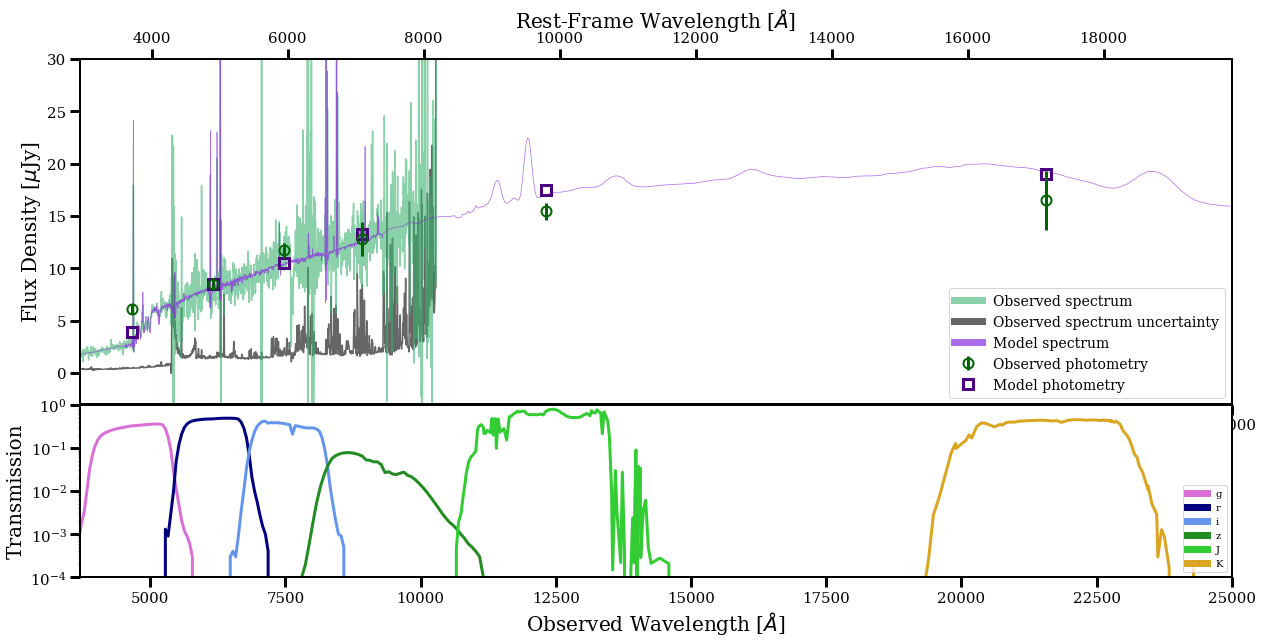

In [29]:
if spec_run_bool == True:
    fig = plt.figure(figsize=(20,12))
    
    # Set observed wavelength min and max
    obs_wmin = 3.7e3
    obs_wmax = 25e3
    
    # Convert to rest-frame min and max for second axis
    zred = mod.params.get('zred') # redshift
    RF_wmin = obs_wmin/(1+zred)
    RF_wmax = obs_wmax/(1+zred)

    ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.4],
                       xlim=(obs_wmin, obs_wmax), ylim =(-3,30)) #, xticklabels=[])
    ax2 = fig.add_axes([0.1, 0.1, 0.8, 0.2], xlim = (obs_wmin, obs_wmax), ylim =(1e-4, 1e0))

    # Adding in Rest-frame wavelength to top axis
    ax3 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

    ax3.set_xlabel(r'Rest-Frame Wavelength [$\AA$]',fontsize =20)  
    ax3.tick_params(axis='x')
    ax3.set_xlim((RF_wmin,RF_wmax))
    
    smooth_by = 11
    
    smooth_spec = savgol_filter(fin['obs_spec'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
    smooth_err = savgol_filter(fin['obs_spec_err'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)
    
        
    # Observed photometry 
    ax1.errorbar(fin['phot_wave'], fin['obs_phot'], yerr = fin['obs_phot_unc'], 
             label='Observed photometry', ecolor='darkgreen', 
             marker='o', markersize=10, ls='', lw=3, alpha=1.0, 
             markerfacecolor='none', markeredgecolor='darkgreen', markeredgewidth=2, zorder=4) 
    
    # Upper Limit
    upper_limit = False
    if upper_limit:
        up_l = np.array([f.wave_effective for f in load_filters(['ukirt_Y'])])
        ax1.plot(up_l, 10**(-0.4*21.93)*3631e6, color='darkgreen', marker='v', markersize=20)
        ulfilt = load_filters(['ukirt_Y'])
        ul_wave = ulfilt[0].wavelength.copy()
        ul_trans = ulfilt[0].transmission.copy()
        ax2.semilogy(ul_wave, ul_trans, alpha=1.0, label='Y', lw=3, color='slategray')
        

    # Observed spectroscopy and error
    ax1.plot(fin['spec_wave'], smooth_spec, color='mediumseagreen', alpha=0.6, 
                 zorder=1, label='Observed spectrum') # binned spec

    ax1.plot(fin['spec_wave'], smooth_err, color='k', alpha=0.6, 
                 zorder=0, label='Observed spectrum uncertainty')
    

    smooth_mod = savgol_filter(fin['model_spec'], window_length=smooth_by, polyorder=3, deriv=0, delta=1.0)

    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='indigo', markeredgewidth=3, zorder=3)

    # Model spectroscopy - just convering spec region
    ax1.plot(fin['full_spec_wave'], smooth_mod, label='Model spectrum',
                 lw=0.7, color='blueviolet', alpha=0.7, zorder=2) 
    
    
    #ax1.plot(fin['spec_wave'], (fin['mspecconv']/fin['mod_cal'])*3631e6, color='k')


    from matplotlib.legend_handler import HandlerLine2D
    def update(handle, orig):
        handle.update_from(orig)
        handle.set_linewidth(7)
    
    # Axis 1 info
    ax1.legend(loc='lower right', fontsize=14,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)

    # Filter transmission curves
    for i in np.arange(0, len(filt_wave), 1):
        ax2.semilogy(filt_wave[i], filt_trans[i]*filt_mult[i], alpha=1.0, label=filt_labels[i], lw=3, color=color_arr[i])

    ax2.legend(loc='lower right', fontsize=10,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
    ax2.set_ylabel(r'Transmission', fontsize=20)


    ax2.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)
    
    ax1.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)
    ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)

    ax3.set_xlabel(r'Rest-Frame Wavelength [$\AA$]', fontsize=20)
    import matplotlib.pyplot as plt

    ax = plt.gca()

    import matplotlib.axes

    ax1.tick_params(width=3, length=10, labelsize=15)
    ax2.tick_params(width=3, length=10, labelsize=15)
    ax3.tick_params(width=3, length=10, labelsize=15)
    
    #ax1.xticks(fontsize=15)
    #ax1.yticks(fontsize=15)
    
    
    #plt.savefig('finalplots/201221D_SED.png', dpi=300)

    plt.show()

In [20]:
# Observed spectroscopy and error
plt.plot(fin['spec_wave'], fin['obs_spec'], color='mediumseagreen', alpha=0.6, 
             zorder=1, label='Observed spectrum') # binned spec

plt.plot(fin['spec_wave'], fin['obs_spec_err'], color='k', alpha=0.6, 
             zorder=0, label='Observed spectrum uncertainty')

KeyError: 'obs_spec'

In [ ]:
path='modelSED/'
outfile='SN2019ofm'
import csv

with open(path+outfile+'_mod_phot.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['wphot', 'mphot'])
    writer.writerows(zip(fin['phot_wave'], fin['model_phot']))

if spec_run_bool == True:
    with open(path+outfile+'_mod_spec.csv', 'w') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['wspec', 'mspec'])
        writer.writerows(zip(fin['full_spec_wave'], fin['model_spec']))
        
        
    #with open(path+outfile+'_mod_spec_lines.csv', 'w') as f:
    #    writer = csv.writer(f, delimiter=',')
    #    writer.writerow(['wspec', 'mspec'])
    #    writer.writerows(zip(fin['spec_wave'], (fin['mspecconv']/fin['mod_cal'])*3631e6))
        
        
else:
    with open(path+outfile+'_mod_spec.csv', 'w') as f:
        writer = csv.writer(f, delimiter=',')
        writer.writerow(['wspec', 'mspec'])
        writer.writerows(zip(fin['spec_wave'], fin['model_spec']))

In [ ]:
path='modelSED/'
outfile='230207A'
import csv

In [31]:
with open(path+outfile+'_spec.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['wave', 'spec', 'err'])
    writer.writerows(zip(fin['spec_wave'], fin['obs_spec'], fin['obs_spec_err']))


In [ ]:
with open(path+outfile+'_norm_factor.csv', 'w') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['wave', 'norm'])
    writer.writerows(zip(fin['spec_wave'],fin['mod_cal']))

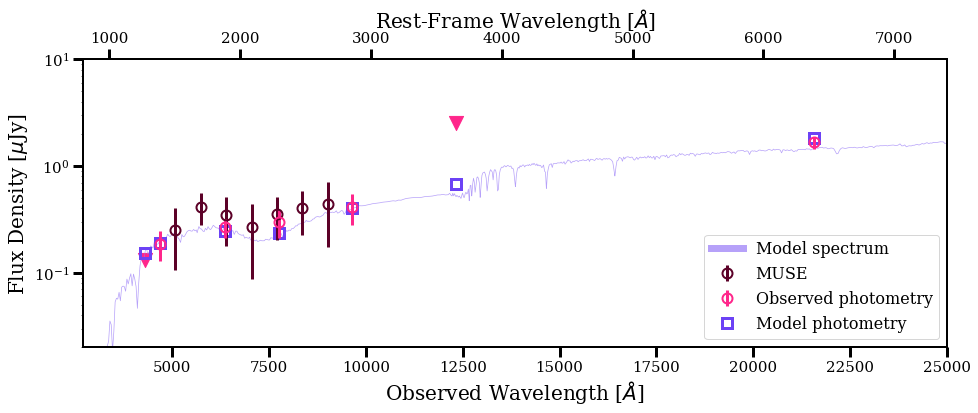

In [18]:
fig = plt.figure(figsize=(15,10))
    
# Set observed wavelength min and max
obs_wmin = 2.7e3
obs_wmax = 25e3
    
# Convert to rest-frame min and max for second axis
zred = mod.params.get('zred') # redshift
RF_wmin = obs_wmin/(1+zred)
RF_wmax = obs_wmax/(1+zred)

ax1 = fig.add_axes([0.1, 0.3, 0.8, 0.4],
                    xlim=(obs_wmin, obs_wmax), ylim =(2e-2, 1e1)) #, xticklabels=[])

# Adding in Rest-frame wavelength to top axis
ax3 = ax1.twiny()  # instantiate a second axes that shares the same x-axis

ax3.tick_params(axis='x')
ax3.set_xlim((RF_wmin,RF_wmax))


# Observed photometry 
ax1.scatter(fin['phot_wave'][0], fin['obs_phot_unc'][0], color='#FF268B', marker='v', s=200) 
ax1.scatter(fin['phot_wave'][1], fin['obs_phot_unc'][1], color='#FF268B', marker='v', s=200) 


#muse_wave = np.array([5209.98, 6129.981, 7049.981, 7971.231, 8891.231])
#muse_flux = np.array([0.341, 0.322, 0.3825, 0.503, 1.063])
#muse_flux_err = np.array([0.147, 0.1689, 0.193, 0.3426, 0.5809])

muse_wave = np.array([5077.981, 5735.481, 6392.981, 7050.481, 7706.731, 8364.231, 9021.731])
muse_flux = np.array([0.253, 0.417, 0.348, 0.266, 0.358, 0.403, 0.4397])
muse_flux_err = np.array([0.147, 0.136, 0.1697, 0.178, 0.156, 0.178, 0.264])


ax1.errorbar(muse_wave, muse_flux, yerr = muse_flux_err, ecolor='#5C0128', 
             marker='o', markersize=10, ls='', lw=3, alpha=1.0, label='MUSE',
             markerfacecolor='none', markeredgecolor='#5C0128', markeredgewidth=2, zorder=4) 

ax1.errorbar(fin['phot_wave'][2:], fin['obs_phot'][2:], yerr = fin['obs_phot_unc'][2:], 
             label='Observed photometry', ecolor='#FF268B', 
             marker='o', markersize=10, ls='', lw=3, alpha=1.0, 
             markerfacecolor='none', markeredgecolor='#FF268B', markeredgewidth=2, zorder=4) 

if spec_run_bool == True:
    # Observed spectroscopy and error
    ax1.semilogy(fin['spec_wave'], fin['obs_spec'], color='mediumseagreen', alpha=0.6, 
                 zorder=1, label='Observed spectrum') # binned spec

    ax1.semilogy(fin['spec_wave'], fin['obs_spec_err'], color='k', alpha=0.6, 
                 zorder=0, label='Observed spectrum uncertainty')
     
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='#6C42F5', markeredgewidth=3, zorder=3)

    # Model spectroscopy - just convering spec region
    ax1.semilogy(fin['full_spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='#9779F7', alpha=0.7, zorder=2)
    


else:
    # Model photometry 
    ax1.errorbar(fin['phot_wave'], fin['model_phot'], label='Model photometry',
                 marker='s', markersize=10, alpha=1.0, ls='', lw=3, 
                 markerfacecolor='none', markeredgecolor='#6C42F5', markeredgewidth=3, zorder=3)

    # Model spectroscopy - full wavelength range
    ax1.semilogy(fin['spec_wave'], fin['model_spec'], label='Model spectrum',
                 lw=0.7, color='#9779F7', alpha=0.7, zorder=2)
    #ax1.vlines(np.array([3727, 3729, 4862, 4932, 5007, 6564])*(1+zred), ymin=1e-3, ymax=1e3)
    
# Upper Limit
upper_limit = False
if upper_limit:
    up_l = np.array([f.wave_effective for f in load_filters(['LRISr_B', 'twomass_J'])])
    ax1.scatter(up_l, [10**(-0.4*25.9)*3631e6, 10**(-0.4*22.9)*3631e6], 
                color='darkgreen', marker='v', s=400)
    
    ulfilt = load_filters(['LRISr_B'])
    ul_wave = ulfilt[0].wavelength.copy()
    ul_trans = ulfilt[0].transmission.copy()
    
    #ax2.semilogy(ul_wave, ul_trans, alpha=1.0, label='i', lw=3, color='limegreen')
    
    
from matplotlib.legend_handler import HandlerLine2D
def update(handle, orig):
    handle.update_from(orig)
    handle.set_linewidth(7)
    
# Axis 1 info
ax1.legend(loc='lower right', fontsize=16,handler_map={plt.Line2D : HandlerLine2D(update_func=update)})
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)


ax1.set_xlabel(r'Observed Wavelength [$\AA$]',fontsize =20)
ax1.set_ylabel(r'Flux Density [$\mu$Jy]', fontsize=20)

ax3.set_xlabel(r'Rest-Frame Wavelength [$\AA$]', fontsize=20)


import matplotlib.pyplot as plt

ax = plt.gca()

import matplotlib.axes

ax.tick_params(width=3)
ax1.tick_params(width=3, length=10, labelsize=15)
ax3.tick_params(width=3, length=10, labelsize=15)

plt.savefig('finalplots/210726A_K_muse_SED.pdf', dpi=400)

plt.show()